# Generative modelling in deep learning
#### Alain Riou - Robin San Roman
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\FF}{\mathcal{F}}$
$\newcommand{\LL}{\mathcal{L}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\XX}{\mathcal{X}}$
$\DeclareMathOperator*{\Diag}{\text{Diag}}$
$\DeclareMathOperator*{\Id}{\text{Id}}$

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

A common way to compare probability distributions is to use $f$-divergences.

Assume that $p_D$ and $p_\theta$ are absolutely continuous with respect to the same measure $\mu$ with densities $q_D$ and $q_\theta$ respectively. Let $\XX$ denote their support.

For $f : \RR \to \RR$ convex such that $f(1) = 0$, the $f$-divergence between $p_D$ and $p_\theta$ is defined as:
$$D_f(p_D \| p_\theta) = \int_{x \in \XX} f \left( \frac{q_D(x)}{q_\theta(x)} \right) q_\theta (x) d\mu(x)$$

One has $D_f(p_D \| p_\theta) = 0$ if and only if $p_D = p_\theta$.

Here are a few examples of $f$-divergences:

- $f : t \mapsto \log t$ corresponds to the Kullback-Leibler divergence.
- $f : t \mapsto \frac{1}{2} \| t - 1 \|$ corresponds to the total variation distance.
- $f : t \mapsto \frac{1}{2} (\sqrt{t} - 1)^2$ corresponds to the square Hellinger distance.

Another way to compare probability distributions is to use integral probability metrics.

They are defined by
$$d_\FF (p_D \| p_\theta) = \sup_{f \in \FF} \EE_{x \sim p_D} \left[ f(x) \right] - \EE_{x \sim p_\theta} \left[ f(x) \right]$$
where $\FF$ is a class of functions from $\XX \to \RR$.

Integral probability metrics are easier to define than $f$-divergences since no density assumptions on the distributions are needed.

Here are a few examples of integral probability metrics:

- $\FF = \left\{ f : \XX \to \RR \ | \ f \text{ is 1-Lipschitz } \right\}$ corresponds to the Wasserstein-1 distance (Earth-Mover distance)
- $\FF = \left\{ f : \XX \to [-1, 1] \ | \ f \text{ is measurable and bounded } \right\}$ corresponds to the total variation distance (that can thus be interpreted as an $f$-divergence or an integral probability metric.

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

If the dimension of $\theta$ is large (which is usually the case when the generator is a neural network), then computing the density of $p_\theta$ is not tractable.

Moreover, expectations cannot be computed formally and must be approximated empirically. Therefore the constructed probability distribution $p_\theta$ should have a low variance so that the empirical mean would be close enough to the actual expectation of the distribution.

Finally, in order to be optimized, the loss function has to be smooth, and so has to be the mapping $\theta \mapsto p_\theta$.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise?**

$N$ has to be big enough so that the constructed distribution $p_\theta$ would be expressive enough.

On the other hand, a too high value of $N$ make the optimization process more difficult, and can also lead to the curse of dimensionality.

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$

So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

As the discriminator gets better, the updates to the generator get worse, and if the generator is poor then the discriminator can reject samples with high confidence.

In that case $\EE_{p_\theta} \left[ - \log (1 - D(x)) \right]$ is close to $0$, and its gradient is also small, thus can vanish.

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

This loss only indicates the quality of the outputs of the generator regardless of their diversity. A generator could thus return the exact same high-quality sample and get a very low loss (*mode collapse*).

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D sinusoidal shape with some noise.

In [0]:
import torch
import math

USE_GPU = torch.cuda.is_available()

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen, use_gpu=USE_GPU):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    t = torch.zeros(batchlen,1).uniform_(-math.pi,math.pi)
    x = t
    y = torch.cos(math.pi*t/4+math.pi/4)**2 + 0.3*torch.cos(2*math.pi*t)
    noise = torch.empty(batchlen, 2).normal_()
    data = torch.cat((x, y), dim=1)
    data += noise * 0.05 * torch.cos(math.pi*t.view(batchlen, 1)/6 + math.pi/2)**2
    if use_gpu:
        data = data.cuda()
    return data

Let's plot a large batch, to see what the dataset looks like.

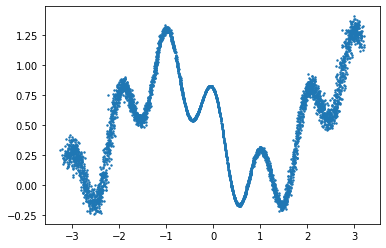

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000, use_gpu=False)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 2)
        
    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        return self.fc5(h)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        if USE_GPU:
            z = z.cuda()
        return self.forward(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc3(h)

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

To enforce the outputs of the neural networks to be in $[0,1]$, a solution is to add a sigmoid as last layer of the network. Let $\sigma : x \mapsto \frac{1}{1 + e^{-x}}$ denote the sigmoid function.

The discriminator loss function thus becomes:
$$\begin{aligned}
\LL_D 
&= \EE_{p_D} \left[ -\log \sigma(D(x)) \right] + \EE_{p_\theta} \left[ -\log \left(1 - \sigma(D(x)) \right) \right] \\
&= \EE_{p_D} \left[ -\log \left( \frac{1}{1 + e^{-D(x)}} \right) \right] + \EE_{p_\theta} \left[ -\log \left(1 - \frac{1}{1 + e^{-D(x)}} \right) \right] \\
&= \EE_{p_D} \left[ \log \left( 1 + e^{-D(x)} \right) \right] + \EE_{p_\theta} \left[ -\log \left( \frac{e^{-D(x)}}{1 + e^{-D(x)}} \right) \right] \\
&= \EE_{p_D} \left[ \log \left( 1 + e^{-D(x)} \right) \right] + \EE_{p_\theta} \left[ \log \left( 1 + e^{D(x)} \right) \right] \\
&= \EE_{p_D} \left[ s(-D(x)) \right] + \EE_{p_\theta} \left[ s(D(x)) \right]
\end{aligned}$$
where $s : x \mapsto \log (1 + e^x)$ is the softplus function, implemented in PyTorch.

Similarly, the generator loss function becomes:
$$\begin{aligned}
\LL_G
&= \EE_{p_\theta} \left[ \log \left(1 - \sigma (D(x)) \right) \right] \\
&= \EE_{p_\theta} \left[ \log \left( \frac{e^{-D(x)}}{1 + e^{-D(x)}} \right) \right] \\
&= \EE_{p_\theta} \left[ - \log \left( 1 + e^{D(x)} \right) \right] \\
&= \EE_{p_\theta} \left[ -s(D(x)) \right] \\
\end{aligned}$$

Using GPU


step 1000: discriminator: 1.381, generator: 0.684


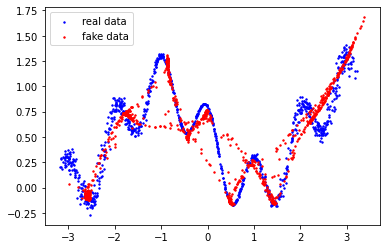

step 2000: discriminator: 1.353, generator: 0.720


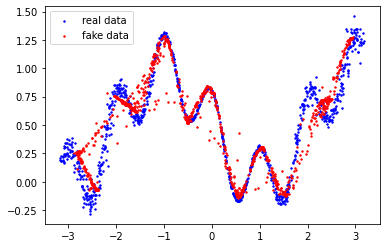

step 3000: discriminator: 1.339, generator: 0.734


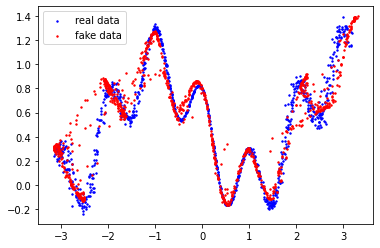

step 4000: discriminator: 1.349, generator: 0.689


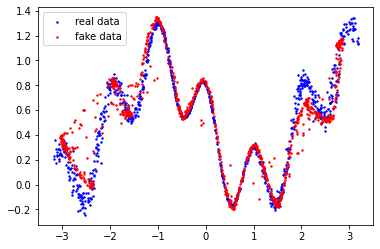

step 5000: discriminator: 1.356, generator: 0.786


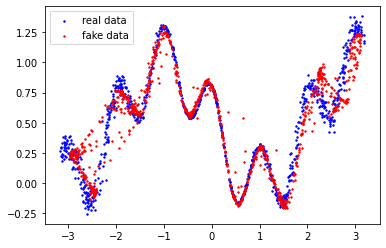

step 6000: discriminator: 1.350, generator: 0.779


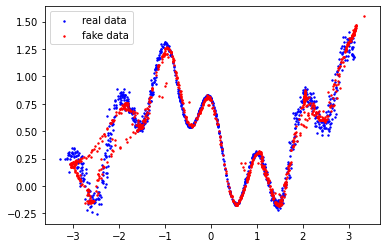

step 7000: discriminator: 1.326, generator: 0.730


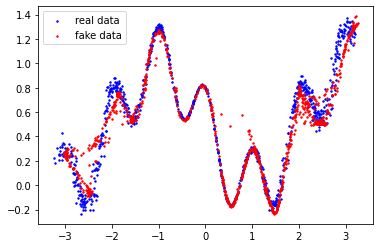

step 8000: discriminator: 1.382, generator: 0.763


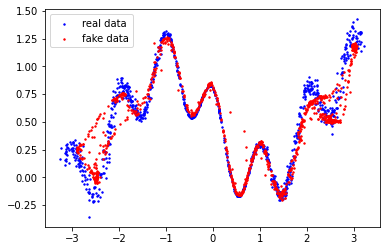

step 9000: discriminator: 1.351, generator: 0.759


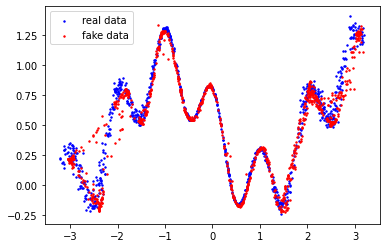

step 10000: discriminator: 1.331, generator: 0.711


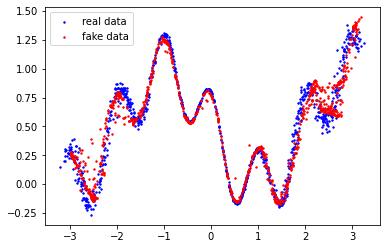

step 11000: discriminator: 1.351, generator: 0.723


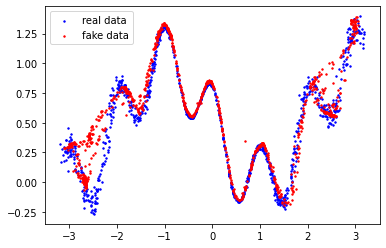

step 12000: discriminator: 1.365, generator: 0.652


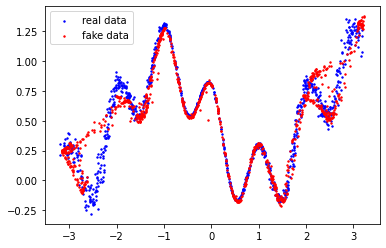

In [14]:
from tqdm.notebook import trange

# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 5
# Total number of training iterations for the generator
N_ITER = 12000
# Batch size to use
BATCHLEN = 128

# reproducibility
torch.manual_seed(0)

generator = Generator()
discriminator = Discriminator()

if USE_GPU:
    print('Using GPU')
    generator = generator.cuda()
    discriminator = discriminator.cuda()
else:
    print('Using CPU')

optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

for i in trange(1, N_ITER+1):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
        #
        disc_loss = torch.mean(
            F.softplus(-discriminator(real_batch)) + \
            F.softplus(discriminator(fake_batch))
        )
        
        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    #
    # == COMPUTE THE GENERATOR LOSS HERE
    #
    gen_loss = torch.mean(F.softplus(-discriminator(fake_batch)))
    
    gen_loss.backward()
    optim_gen.step()
    if i % 1000 == 0:
        print('step {}: discriminator: {:.3f}, generator: {:.3f}'.format(i, disc_loss.item(), gen_loss.item()))
        # plot the result
        real_batch = generate_batch(1024, use_gpu=False)
        fake_batch = generator.generate(1024).detach().cpu().numpy()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, c='b', label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, c='r', label='fake data')
        plt.legend()
        plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

First, $f : x \mapsto -\log x$ is a convex function whereas $g : x \mapsto \log(1 - x)$ is concave on $[0, 1]$. It is thus easier to minimize $f$ than $g$ with a gradient descent algorithm.

Moreover, 

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

- **depth / width of the generator network**: Two hidden layers were not expressive enough, and more than five led to slower training and worse performance. It also seems that increasing the width above $\sim 200$ does not help.

- **depth / width of the discriminator network**: Making the discriminator more complex (i.e adding layers or increasing width) strongly encourages mode collapse.

- **impact of `TRAIN_RATIO`**: A value of $3$ seems optimal with the architecture I used.

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \log p_\theta(x)$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.

**Q8: Prove this equivalence.**

$$\begin{aligned}
D_{\text{KL}}(p_D \| p_\theta)
&= \int_{x \in \XX} p_D(x) \log \left( \frac{p_D(x)}{p_\theta(x)} \right) dx \\
&= \EE_{x \sim p_D} \left[ \log \left( \frac{p_D(x)}{p_\theta(x)} \right) \right] \\
&= \EE_{x \sim p_D} \log p_D(x) - \EE_{x \sim p_D} \log p_\theta(x)
\end{aligned}$$

Since $\EE_{x \sim p_D} \log p_D(x)$ does not depend on $\theta$, minimize $D_{\text{KL}}(p_D \| p_\theta)$ is equivalent to minimize $- \EE_{x \sim p_D} \log p_\theta(x)$, i.e. maximize $\EE_{x \sim p_\theta} \log p_\theta(x)$.

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms form a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

Since $p(z)$ is never sampled, the KL-divergence term of the loss cannot be empirically estimated. Therefore one has to make assumptions on the form of its form so that this term becomes at least analytically computable.

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

Recall that the density function of a multivariate Gaussian distribution $\NN(\mu, \Sigma)$ is:
$$p(z) = \frac{1}{(2\pi)^{n/2} \det(\Sigma)^{1/2}} \exp \left( -\frac{1}{2} (z - \mu)^\top \Sigma^{-1} (z - \mu) \right)$$
where $n$ is the dimension of the space $z$ is in.

Let $\Sigma_\phi(x) = \Diag(\sigma_\phi^2(x))$ be the covariance matrix of $q(\cdot | x)$ and $\sigma_\phi(x)_i$ be the $i$-th component of $\sigma_\phi(x)$ for $i$ in $\{1, \dots, n\}$ and $x \in \XX$.
<!-- 
One has thus:
$$q_\phi(z | x) = \frac{1}{(2\pi  \prod_i \sigma_\phi^2(x)_i)^{n/2}} \exp \left( -  \sum_i \frac{\|z - \mu_\phi(x) \|^2}{2 \sigma_\phi^2(x)} \right)$$
and
$$p(z) = \frac{1}{(2 \pi)^{n/2}} \exp \left( - \frac{\|z\|^2}{2} \right)$$ -->

$$\begin{aligned}
D_{\text{KL}}(q_\phi(z|x) \| p(z))
&= \EE_{z \sim q_\phi(\cdot|x)} \left[ \log q_\phi(z|x) - \log p(z) \right] \\
&= \EE_{z \sim q_\phi(\cdot|x)} \left[ -\frac{n}{2}\log 2 \pi - \frac{1}{2} \log \det \Sigma_\phi(x) - \frac{1}{2} (z - \mu_\phi(x))^\top \Sigma_\phi^{-1}(x) (z - \mu_\phi(x)) + \frac{n}{2} \log 2\pi + \frac{1}{2} z^\top z \right] \\
&= \frac{1}{2} \EE_{z \sim q_\phi(\cdot|x)} \left[ z^\top z - (z - \mu_\phi(x))^\top \Sigma_\phi^{-1}(x) (z - \mu_\phi(x)) \right] - \sum_i \log {\sigma_\phi(x)_i} \\
&= \frac{1}{2} \left( \EE_{z \sim q_\phi(\cdot|x)} \left[ z^\top z \right] - \sum_i \frac{1}{\sigma_\phi^2(x)_i} \EE_{z \sim q_\phi(\cdot|x)} \left[ \left(z_i - \mu_\phi(x)_i \right)^2 \right] \right) - \sum_i \log {\sigma_\phi(x)_i}
\end{aligned}$$

Recall that $\Sigma$ is the covariance matrix of $q_\phi(\cdot|x)$. For all $i \in \{1, \dots, n\}$, one has thus:
$$\begin{aligned}
\sigma_\phi^2(x)_i
&= \EE_{z \sim q_\phi(\cdot|x)} \left[ \left( z_i - \EE_{z \sim q_\phi(\cdot|x)} z_i \right)^2 \right] \\
&= \EE_{z \sim q_\phi(\cdot|x)} \left[ \left( z_i - \mu_\phi(x)_i \right)^2 \right]
\end{aligned}$$

Therefore:
$$\begin{aligned}
\sum_i \frac{1}{\sigma_\phi^2(x)_i} \EE_{z \sim q_\phi(\cdot|x)} \left[ \left(z_i - \mu_\phi(x)_i \right)^2 \right]
&= n
\end{aligned}$$
and
$$\begin{aligned}
\EE_{z \sim q_\phi(\cdot|x)} \left[ z^\top z \right]
&= \EE_{z \sim q_\phi(\cdot|x)} \left[ (\mu_\phi(x) + z - \mu_\phi(x))^\top (\mu_\phi(x) + z - \mu_\phi(x)) \right] \\
&= \mu_\phi(x)^\top \mu_\phi(x) + 2 \mu_\phi(x) \underbrace{\EE_{z \sim q_\phi(\cdot|x)} \left[ z - \mu_\phi(x) \right]}_{= 0} + \EE_{z \sim q_\phi(\cdot|x)} \left[ (z - \mu_\phi(x))^\top (z - \mu_\phi(x)) \right] \\
&= \| \mu_\phi(x) \|^2 + \| \sigma_\phi(x) \|^2
\end{aligned}$$

Finally,
$$D_{\text{KL}}(q_\phi(z|x) \| p(z) ) = \frac{1}{2} \left( \| \mu_\phi(x) \|^2 + \| \sigma_\phi(x) \|^2 - n \right) - \sum_i \log \sigma_\phi(x)_i$$

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); \Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

Let $\Sigma_\theta(z) = \Diag(\sigma_\theta^2(z))$  be the covariance matrix of $p_\theta( \cdot | z)$.

One has
$$p_\theta(x | z) = \frac{1}{(2\pi)^{n/2} \det(\Sigma_\theta(z))^{1/2}} \exp \left( -\frac{1}{2} (x - \mu_\theta(z))^\top \Sigma_\theta^{-1}(z) (x - \mu_\theta(z)) \right)$$

Then
$$\begin{aligned}
- \log p_\theta(x | z)
&= \frac{1}{2} \left( n \log 2 \pi + \log \det \Sigma + (x - \mu_\theta(z))^\top \Sigma_\theta^{-1}(z) (x - \mu_\theta(z)) \right) \\
&= \frac{1}{2} \sum_i \left( \log 2 \pi + \log \sigma_\theta^2(z)_i + \frac{(x_i - \mu_\theta(z)_i)^2}{\sigma_\theta^2(z)_i} \right) \\
&= \sum_i \frac{(x_i - \mu_\theta(z)_i)^2}{2 \sigma_\theta^2(z)_i} + \sum_i \log \sigma_\theta(z)_i + \frac{n}{2} \log 2 \pi
\end{aligned}$$

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [0]:
# Choose a value for the latent dimension
LATENT_N = 1

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(2, 16)
        self.fc_mu = nn.Linear(16, LATENT_N)
        self.fc_logvar = nn.Linear(16, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def forward(self, x):
        h = F.relu(self.fc(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(LATENT_N, 8)
        self.fc2 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc_mu = nn.Linear(16, 2)
        self.fc_logvar = nn.Linear(16, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def forward(self, z, var=None):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h) if var is None else torch.log(var)
        return (mu, logvar)

    def generate(self, batchlen, var=None):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        if USE_GPU:
            z = z.cuda()
        (mu, logvar) = self.forward(z, var=var)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. Pytorch allows us to sample the Gaussian distribution using `torch.normal(mu, sigma)`, but it is not differentiable wrt to its inputs.

**Q12: How can you sample a distribution $\mathcal{N}(\mu, \sigma)$ is a way that is differentiable w.r.t. both $\mu$ and $\sigma$?**

In *Auto-Encoding Variational Bayes* (Kingma *et al.*, 2013), the authors show that for $\epsilon \sim \NN(0, \Id)$, the vector
$$z = \mu + \Diag(\sigma) \epsilon$$
follows distribution $\NN(\mu, \sigma)$. This quantity is obviously differentiable w.r.t $\mu$ and $\sigma$.

Using GPU


step 1000: KL: 2.826e+01, rec: -1.007e+01


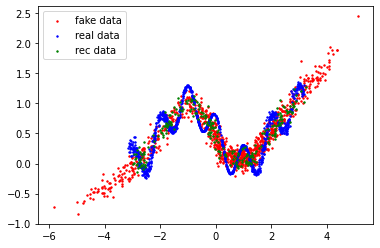

step 2000: KL: 2.273e+01, rec: -1.218e+01


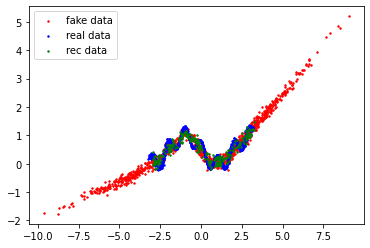

step 3000: KL: 2.150e+01, rec: -1.269e+01


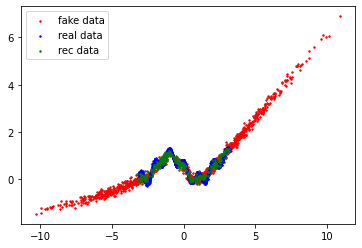

step 4000: KL: 2.095e+01, rec: -1.370e+01


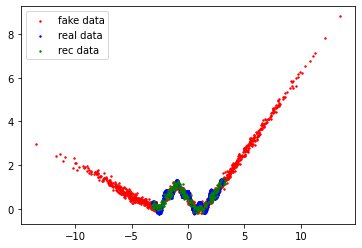

step 5000: KL: 2.070e+01, rec: -1.393e+01


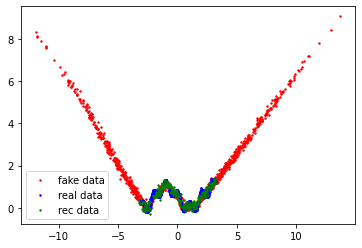

step 6000: KL: 2.045e+01, rec: -1.394e+01


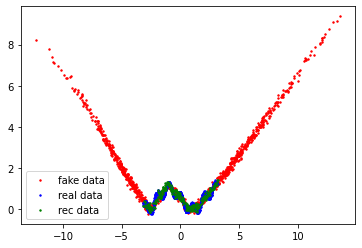

step 7000: KL: 2.056e+01, rec: -1.381e+01


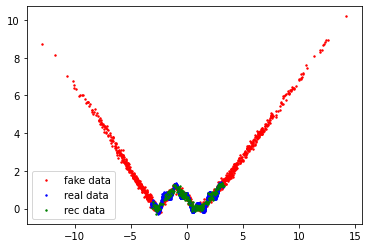

step 8000: KL: 2.056e+01, rec: -1.403e+01


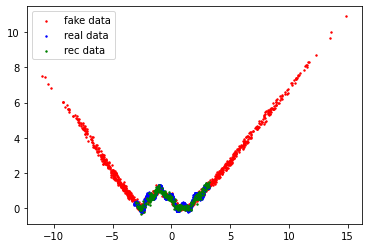

step 9000: KL: 2.077e+01, rec: -1.367e+01


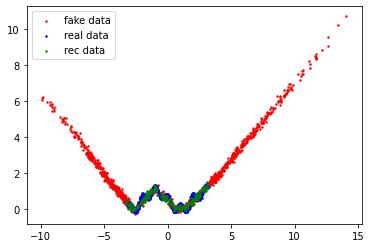

step 10000: KL: 2.049e+01, rec: -1.417e+01


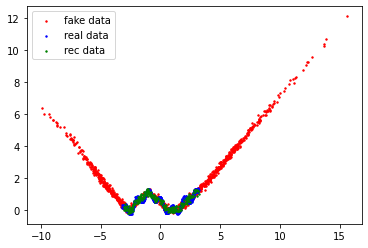

step 11000: KL: 2.065e+01, rec: -1.394e+01


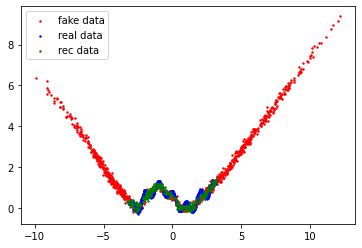

step 12000: KL: 2.048e+01, rec: -1.420e+01


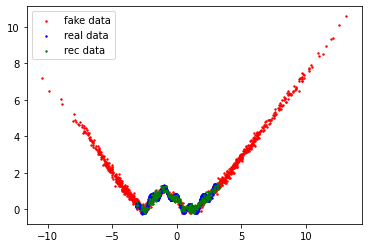

step 13000: KL: 2.053e+01, rec: -1.413e+01


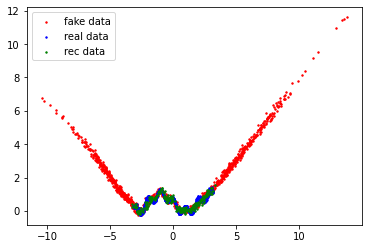

step 14000: KL: 2.053e+01, rec: -1.396e+01


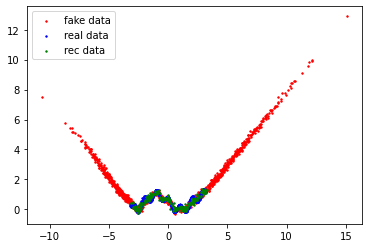

step 15000: KL: 2.062e+01, rec: -1.463e+01


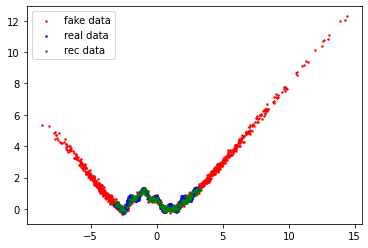

step 16000: KL: 2.059e+01, rec: -1.487e+01


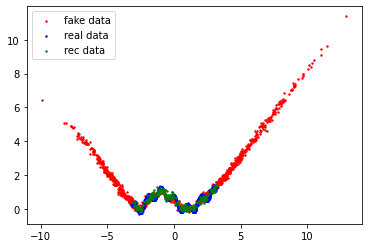

step 17000: KL: 2.062e+01, rec: -1.467e+01


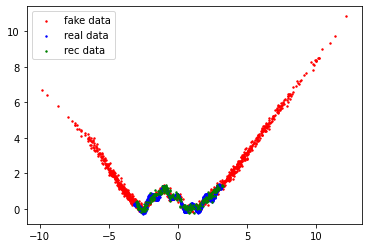

step 18000: KL: 2.059e+01, rec: -1.445e+01


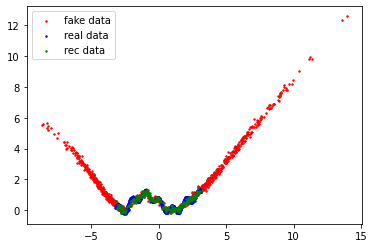

step 19000: KL: 2.050e+01, rec: -1.430e+01


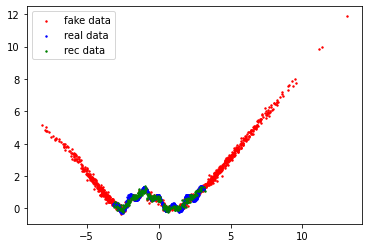

step 20000: KL: 2.067e+01, rec: -1.465e+01


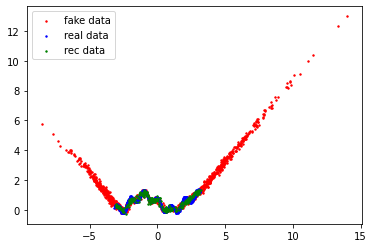

step 21000: KL: 2.047e+01, rec: -1.427e+01


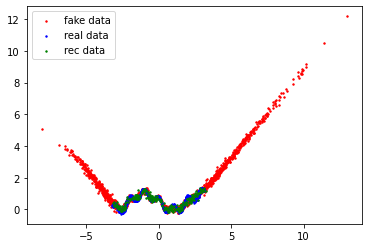

step 22000: KL: 2.061e+01, rec: -1.513e+01


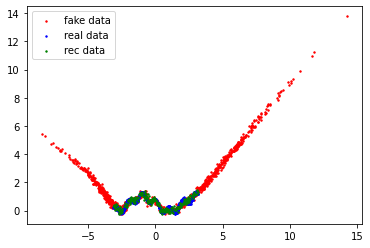

step 23000: KL: 2.051e+01, rec: -1.476e+01


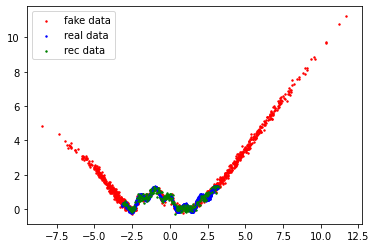

step 24000: KL: 2.072e+01, rec: -1.507e+01


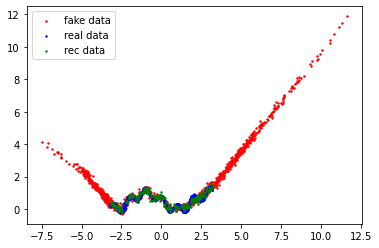

step 25000: KL: 2.086e+01, rec: -1.481e+01


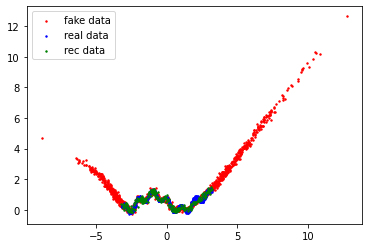

step 26000: KL: 2.065e+01, rec: -1.497e+01


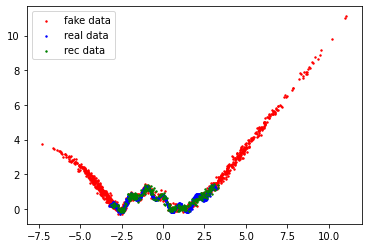

step 27000: KL: 2.070e+01, rec: -1.432e+01


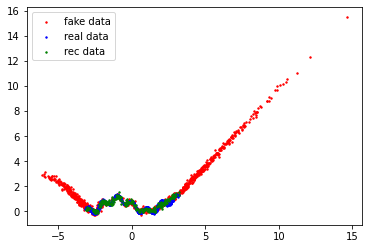

step 28000: KL: 2.067e+01, rec: -1.478e+01


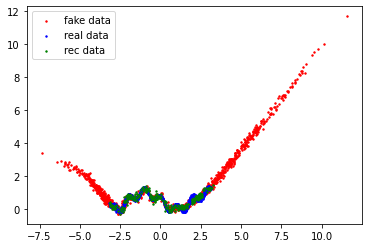

step 29000: KL: 2.074e+01, rec: -1.513e+01


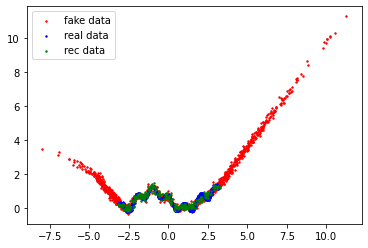

step 30000: KL: 2.075e+01, rec: -1.506e+01


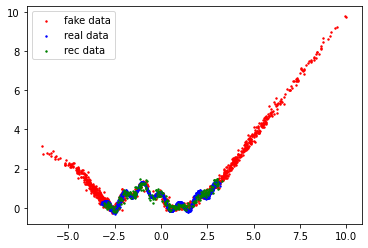

step 31000: KL: 2.049e+01, rec: -1.511e+01


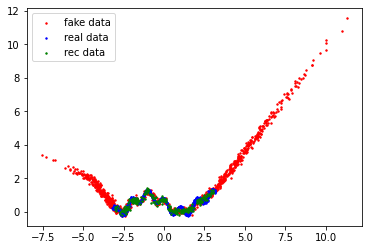

step 32000: KL: 2.071e+01, rec: -1.517e+01


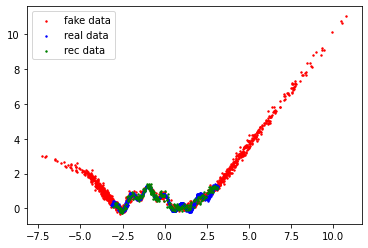

step 33000: KL: 2.059e+01, rec: -1.505e+01


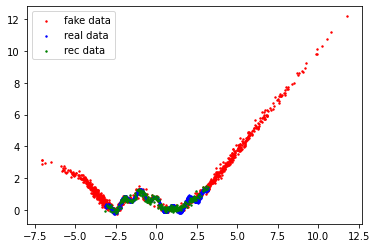

step 34000: KL: 2.066e+01, rec: -1.481e+01


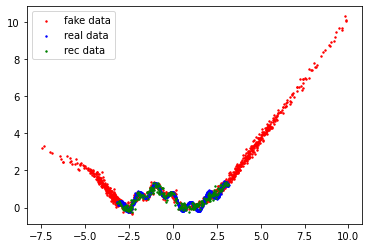

step 35000: KL: 2.061e+01, rec: -1.454e+01


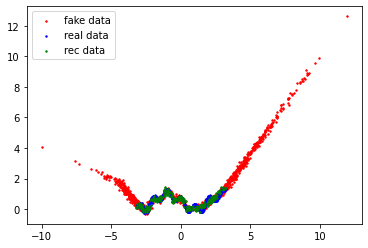

step 36000: KL: 2.057e+01, rec: -1.524e+01


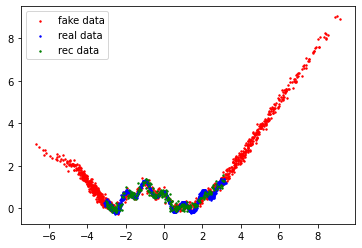

step 37000: KL: 2.070e+01, rec: -1.522e+01


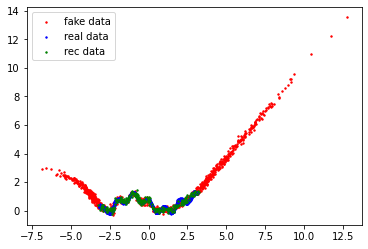

step 38000: KL: 2.073e+01, rec: -1.498e+01


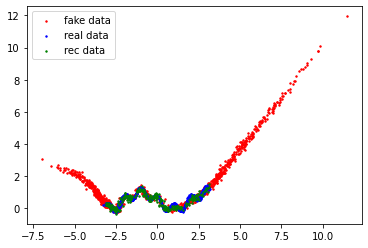

step 39000: KL: 2.062e+01, rec: -1.537e+01


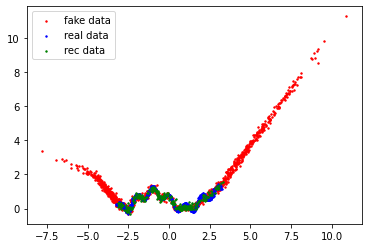

step 40000: KL: 2.072e+01, rec: -1.517e+01


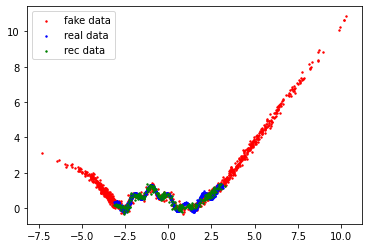

In [46]:
# Total number of training iterations for the VAE
N_ITER = 40000
# Batch size to use
BATCHLEN = 256

VAR = torch.tensor([0.01, 0.01]) # \sigma_\theta^2
if USE_GPU and VAR is not None:
    VAR = VAR.cuda()

# reproducibility
torch.manual_seed(0)

encoder = Encoder()
decoder = Decoder()

if USE_GPU:
    print('Using GPU')
    encoder = encoder.cuda()
    decoder = decoder.cuda()
else:
    print('Using CPU')

optim_enc = torch.optim.Adam(encoder.parameters())#, lr=1e-3, betas=(0.5,0.9))
optim_dec = torch.optim.Adam(decoder.parameters())#, lr=1e-3, betas=(0.5,0.9))

for i in trange(1, N_ITER+1):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    loss_kl = torch.mean(
        torch.norm(enc_mu, p=2) + \
        torch.norm(torch.exp(enc_logvar), p=1) - \
        2*torch.sum(enc_logvar, dim=1)
    )
    #
    # SAMPLE z FROM q(z|x) HERE
    #
    eps = torch.normal(torch.zeros((BATCHLEN, LATENT_N)), 1)
    if USE_GPU:
        eps = eps.cuda()
    z = enc_mu + torch.exp(enc_logvar/2)*eps
    
    dec_mu, dec_logvar = decoder(z, var=VAR)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    loss_rec = 2*torch.mean(
        (x - dec_mu)**2/(torch.exp(dec_logvar)) + \
        2*dec_logvar
    )
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024, use_gpu=False)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach().cpu().numpy()
        fake_batch = decoder.generate(1024, var=VAR).detach().cpu().numpy()
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, c='r', label='fake data')
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, c='b', label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, c='g', label='rec data')
        plt.legend()
        plt.show()

**Q13: Try hardcoding $\sigma_\theta(z)$ to some small value (like 0.01) rather than allowing the decoder to learn it. What does it change?**

When $\sigma_\theta(z)$ is hardcoded, optimizing the reconstruction loss becomes equivalent to minimizing the Mean Squared Error between $x$ and $\mu_\theta(z)$.

The effect of that is that the task of the network is easier, therefore it converges much faster. Moreover, since the standard deviation $\sigma_\theta(z)$ is fixed, it cannot diverge so that it is less likely to produce outliers than when it is estimated.

However, hardcoding $\sigma_\theta(z)$ instead of estimating it reduces the expressiveness of the VAE. It is not an issue in the specific case of this practical since the noise of the data is generated from a normal distribution, but is in the general case a strong assumption that can make the VAE unable to approximate the requested distribution.

**Q14: How do the power of encoder and decoder affect the overall training of the VAE?**

> (Write your answer here)

**Q15: As a conclusion, how would you compare the advantages and shortcomings of GANs and VAEs?**

VAEs are a probabilistic grphical model whose explicit goal is latent modelling, and thus can make good generations where the latent is important. For high-dimensional inputs, the VAE naturally collapses most dimensions in the latent representations so that dimensions in the latent space are very interpretable.

In the other hand, GANs are explicitly set up to optimize for generative tasks, and clearly achieve nicer results on problems like the one of this practical. However, GANs can miss modes and thus lack of diversity if all their parameters are not correctly set up.

As a conclusion, not one architecture is intrinsically better than one other, and the best choice usually depends on the problem to be solved since advantages and shortcomings of both architectures are very different. Some papers try to overcome the limitations of these architectures, and others also tried to combine both architectures into one (VAE-GANs) that combine the strengths of VAEs and GANs while cancelling their respective shortcomings (see [*Autoencoding beyond pixels using a learned similarity metric*](https://arxiv.org/abs/1512.09300), Larsen *et al.*).